In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
tf.__version__

'2.3.0'

In [36]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
train_images = x_train.reshape(x_train.shape[0],28,28,1).astype("float32")
train_images = train_images/255.0
y_train = y_train.astype("float32")
y_train = tf.keras.utils.to_categorical(y_train,10)

samples = 128

train_dataset = tf.data.Dataset.from_tensor_slices((train_images , y_train)).batch(samples , drop_remainder = True)

In [37]:
def combine_vectors(x,y):
     #combining two vectors x,y 

     
    combined = tf.concat([x,y] , axis = -1)
    return combined

#testing...
noise = tf.random.normal([1,64])
one_hot = tf.random.normal([1,10])
test = combine_vectors(noise,one_hot)
test.shape

TensorShape([1, 74])

In [67]:
def embedded_channels(x,one_hot,n_classes): #[128,28,28,1]
    #creating one_hot channels


    batch,m,n,_ = x.shape
    test_image = tf.repeat(one_hot,[m*n])
    test_image = tf.reshape(test_image,[batch,28,28,n_classes])
    test_image
    
    return test_image
    
#testing....
image = tf.random.normal([128,28,28,1])
one_hot = tf.random.normal([128,10])
test = embedded_channels(image,one_hot,10)
test.shape


TensorShape([128, 28, 28, 10])

In [39]:
def get_noise(n_samples,z_dim):
    #getting random noise vector for image generation

    return tf.random.normal([n_samples,z_dim])

In [40]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(64+10,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model
        

    

In [41]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64,(5,5), strides = (2,2) , padding = "same"  ,input_shape = (28,28,11)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    
    model.add(tf.keras.layers.Conv2D(128,(5,5), strides = (2,2) , padding = "same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1 , activation = "sigmoid" ))
    
    
    return model


In [42]:
gen = generator()
disc = discriminator()
bce = tf.losses.BinaryCrossentropy()

In [43]:
def gen_loss(fake_output):
    
    
    return bce(tf.ones_like(fake_output) , fake_output )
    
    
    
    

def disc_loss(fake_output,real_output):
    
    fake_loss = bce(tf.zeros_like(fake_output),fake_output)
    real_loss = bce(tf.ones_like(real_output),real_output)
    total_loss = (fake_loss + real_loss)
    
    
    
    return total_loss





In [44]:
gen_optimizer = tf.optimizers.Adam(0.002,0.5,0.999)
disc_optimizer = tf.optimizers.Adam(0.0002,0.5,0.999)


In [45]:
epochs = 50
z_dim = 64
n_classes = 10

In [46]:
@tf.function
def train_step(real_images , one_hot_y):
    
    
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        noise = get_noise(samples,z_dim)
        embedded_noise = combine_vectors(noise,one_hot_y)
        channels = embedded_channels(real_images,one_hot_y,n_classes)
        embedded_image = combine_vectors(real_images,channels)
        #####################################
        fake_image = gen(embedded_noise , training = True)
        fake_emb_image = combine_vectors(fake_image,channels)
        fake_output = disc(fake_emb_image , training = True)
        real_output = disc(embedded_image , training = True)
    
        ####################################

        g_loss = gen_loss(fake_output)
        d_loss = disc_loss(fake_output,real_output)
        
    gen_grad = gen_tape.gradient(g_loss , gen.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grad,gen.trainable_variables))
        
    disc_grad = disc_tape.gradient(d_loss , disc.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_grad , disc.trainable_variables))
    return g_loss ,d_loss  
        
        
        
    

In [47]:
def train(dataset,epoch):
    mean_gen_loss_list = []
    mean_disc_loss_list = []

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        for image , y_hot in dataset:
            
            g_loss, d_loss , = train_step(image , y_hot)
            
            gen_loss_list.append(g_loss)
            disc_loss_list.append(d_loss)
            
        mean_g_loss = sum(gen_loss_list)/len(gen_loss_list)
        mean_d_loss = sum(disc_loss_list)/len(disc_loss_list)
        mean_gen_loss_list.append(mean_g_loss)
        mean_disc_loss_list.append(mean_d_loss)    
            
        print (f'Epoch {epoch+1}, gen loss={mean_g_loss},disc loss={mean_d_loss}')
        
    return mean_gen_loss_list , mean_disc_loss_list    
        

In [48]:
G_loss , D_loss = train(train_dataset,epochs)

Epoch 1, gen loss=0.6142616868019104,disc loss=1.6009879112243652
Epoch 2, gen loss=0.6875748038291931,disc loss=1.3986800909042358
Epoch 3, gen loss=0.6929887533187866,disc loss=1.387782335281372
Epoch 4, gen loss=0.7133200764656067,disc loss=1.363207459449768
Epoch 5, gen loss=0.7968214750289917,disc loss=1.2832533121109009
Epoch 6, gen loss=1.0036646127700806,disc loss=1.0703314542770386
Epoch 7, gen loss=1.216791033744812,disc loss=0.878300130367279
Epoch 8, gen loss=1.4847126007080078,disc loss=0.6974454522132874
Epoch 9, gen loss=1.7026333808898926,disc loss=0.5687386989593506
Epoch 10, gen loss=1.9175283908843994,disc loss=0.4732576012611389
Epoch 11, gen loss=1.9808180332183838,disc loss=0.4585741460323334
Epoch 12, gen loss=2.260652542114258,disc loss=0.3743920624256134
Epoch 13, gen loss=2.3289237022399902,disc loss=0.33025458455085754
Epoch 14, gen loss=2.318223237991333,disc loss=0.3577669560909271
Epoch 15, gen loss=2.5165536403656006,disc loss=0.3063790500164032
Epoch 16,

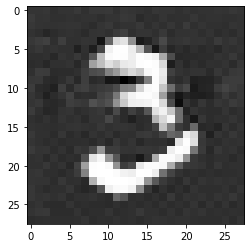

In [51]:
noise = tf.random.normal([1,64])
digit_hot_vector = np.array([0,0,0,1,0,0,0,0,0,0]).reshape(1,10)

embedded_noise = combine_vectors(noise,digit_hot_vector)
test_image = gen(embedded_noise).numpy()

image = test_image.reshape(28,28)
plt.imshow(image*255,cmap="gray")

shape of embedded noise vector: (10, 74)


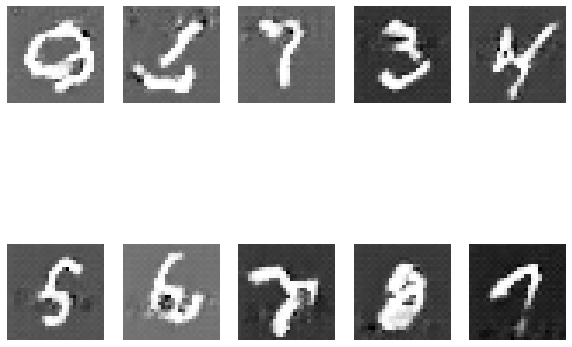

In [65]:

noises = np.random.rand(10,64)
digits = np.array([0,1,2,3,4,5,6,7,8,9])
one_hot_vectors = tf.keras.utils.to_categorical(digits , 10)
emb_noise = combine_vectors(noises , one_hot_vectors) 
print("shape of embedded noise vector:",emb_noise.shape)
images = gen(emb_noise).numpy().reshape(10,28,28)


fig , ax = plt.subplots(2,5 , figsize = (10,8))

for j in range(2):
  for i in range(5):
    plt.sca(ax[j][i])
    if j == 0:
      plt.imshow(images[i] , cmap = "gray")
    else:
      plt.imshow(images[i+5],cmap = "gray")
    plt.axis("off")
    

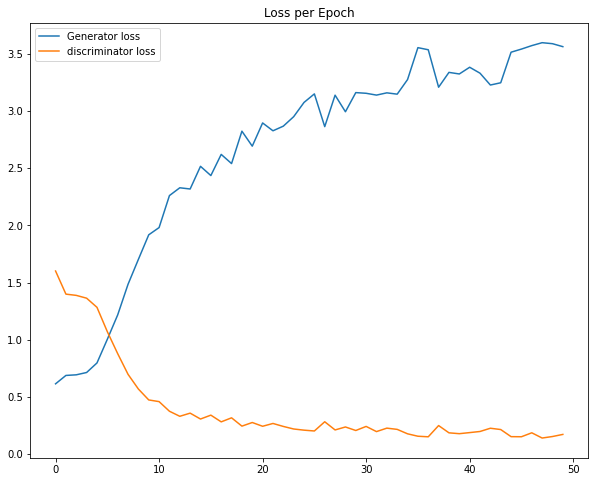

In [66]:
plt.figure(figsize=(10,8))
plt.plot(G_loss , label = "Generator loss" , linewidth = 1.5)
plt.plot(D_loss, label = "discriminator loss" , linewidth = 1.5)
plt.legend()
plt.title("Loss per Epoch")
plt.show()

    
